In [6]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft2, irfft2
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

y, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None

# with h5py.File(Z:\\files\\simulation_2d.h5, "r") as data: # 
#     y = data["y"][:]
#     Hs = data["Hs"][:]
#     Tp = data["Tp"][:]
#     time = data["time"][:]

#     modes = data.attrs["modes"]
#     length = data.attrs["length"]
#     Ta = data.attrs["Ta"]
#     x = np.linspace(0, length, 2*modes)

# index = np.argmin(np.abs(time - 2*Ta))
# y = y[:, index:]
# time = time[index:] - time[index]
# eta_hat = y[0, :, 0]

with h5py.File(h5_files[1], "r") as data:
    y = data["y"][:]
    Hs = data.attrs["Hs"]
    Tp = data.attrs["Tp"]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = 100

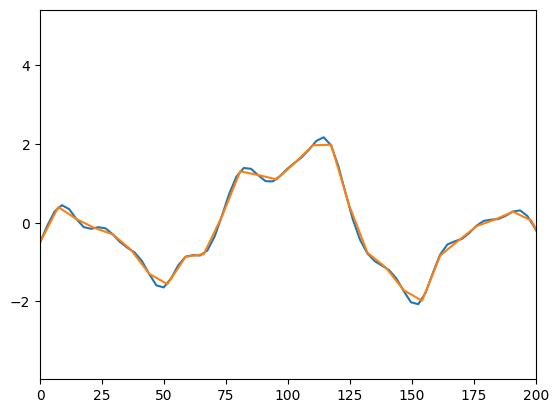

(901, 410, 206)


In [ ]:
eta_hat = y[index:, 0, : :].copy()
modes = eta_hat.shape[-2] // 2

x = np.linspace(0, 3000, eta_hat.shape[-2])
plt.plot(x, np.fft.irfft2(eta_hat[0, :, :])[0, :])

mHOS = 4
alias_mask = np.arange(modes+1) < modes * 2 / (mHOS + 1) + 1
alias_mask_long = np.concatenate((alias_mask, alias_mask[2:][::-1]))
eta_hat = eta_hat[:, alias_mask_long, :]
eta_hat = eta_hat[:, :, alias_mask]

new_modes = np.sum(alias_mask)-1
eta_hat[:, new_modes, :] = np.real(eta_hat[:, new_modes, :])
eta_hat[:, :, -1] = np.real(eta_hat[:, :, -1])
eta_hat *= new_modes * new_modes / (modes * modes)

x = np.linspace(0, 3000, eta_hat.shape[-2])
plt.plot(x, np.fft.irfft2(eta_hat[0, :, :])[0, :])
plt.xlim(0, 200)
plt.show()

modes = new_modes

print(eta_hat.shape)

In [26]:
# Creating dataset

prediction_time = 60 # 140 sec
measure_time = 60 # one minute
num_measurements = 6
step = int(measure_time / num_measurements)

train_percentage = 0.7

X = eta_hat[:-prediction_time]
y = eta_hat[prediction_time+measure_time:-1]

X = irfft2(X)
y = irfft2(y)

mes_index_1 = np.argmin(np.abs(x - 1300))
mes_index_2 = np.argmin(np.abs(x - 1700))

X[:, mes_index_1:mes_index_2, mes_index_1:mes_index_2] = 0

# Create dataset using 6 measurements with 10 sec inbetween

X = np.stack([
    X[0*step:-measure_time+0*step-1],
    X[1*step:-measure_time+1*step-1],
    X[2*step:-measure_time+2*step-1],
    X[3*step:-measure_time+3*step-1],
    X[4*step:-measure_time+4*step-1],
    X[5*step:-measure_time+5*step-1],
    X[6*step:-measure_time+6*step-1],
], axis=1)

# Split into train and test

X_train = X[:int(X.shape[0]*train_percentage), :, :]
X_test = X[int(X.shape[0]*train_percentage):, :, :]
y_train = y[:int(y.shape[0]*train_percentage), :]
y_test = y[int(y.shape[0]*train_percentage):, :]

# Only need std to normalize 

std = np.std(X_train)
X_train = X_train / std
y_train = y_train / std

print(X_train.shape, y_train.shape)

(546, 7, 410, 410) (546, 410, 410)


In [28]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO1d, FNO2d

device = torch.device("cpu")

# to PyTorch tensors
X_t = torch.from_numpy(X_train).float()
y_t = torch.from_numpy(y_train).float()

dataset = TensorDataset(X_t, y_t)
loader  = DataLoader(dataset, batch_size=16, shuffle=True)

model     = FNO2d(in_channels=X_train.shape[1], out_channels=1, width=16, modes_height=64, modes_width=64, depth=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

early_stopping_rounds = 5

early_stopping_count = 0
best_loss = np.inf

loss_mask = np.zeros(y_train.shape[1:])
loss_mask[mes_index_1:mes_index_2, mes_index_1:mes_index_2] = 1
loss_mask = torch.tensor(loss_mask, dtype=torch.float32).to(device)
loss_correction = modes * modes

model.train()
for epoch in range(1, 101):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred*loss_mask, yb*loss_mask) * loss_correction / torch.sum(loss_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(loader)

    if avg < best_loss:
        best_loss = avg
        early_stopping_count = 0
        torch.save(model.state_dict(), "best_FNO.pt")
        print(f"Saved new best model at epoch {epoch} with loss {avg:.6f}")
    else:
        early_stopping_count += 1
        if early_stopping_count > early_stopping_rounds:
            print("early_stopping")
            break

    print(f"Epoch {epoch:3d} — train MSE: {avg:.6f}")

Saved new best model at epoch 1 with loss 1.249391
Epoch   1 — train MSE: 1.249391


KeyboardInterrupt: 

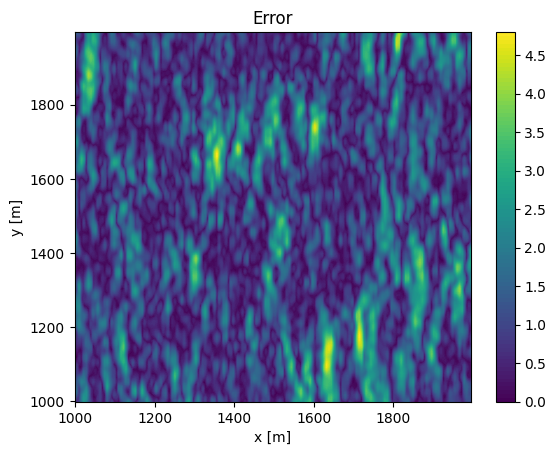

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from FNO import FNO1d, FNO2d

device = torch.device("cpu")

model = FNO2d(in_channels=X_train.shape[1], out_channels=1, width=16, modes_height=32, modes_width=32, depth=2)
model.load_state_dict(torch.load("best_FNO_2d.pt", map_location=device))
model.eval() 

X_tensor = torch.from_numpy(X_test / std).float().to(device)
random_indices = torch.randperm(X_tensor.shape[0])[:9]

X_test_subset = X_tensor[random_indices] 
y_test_subset = y_test[random_indices]
y_pred = None
with torch.no_grad():
    y_pred = model(X_test_subset).cpu().numpy() * std

index = 0
error = np.abs(y_pred[index, mes_index_1:mes_index_2, mes_index_1:mes_index_2] - y_test_subset[index, mes_index_1:mes_index_2, mes_index_1:mes_index_2])
plt.contourf(x[mes_index_1:mes_index_2], x[mes_index_1:mes_index_2], error, levels=100)
plt.colorbar()
plt.title("Error")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

# plt.plot(x[mes_index_1:mes_index_2], y_pred[index, y_pred.shape[1]//2, mes_index_1:mes_index_2].cpu().numpy(), label="Prediction", color="k", linestyle="--")
# plt.plot(x[mes_index_1:mes_index_2], y_test[index, y_pred.shape[1]//2, mes_index_1:mes_index_2], label="Ground Truth", color="b")

# RMSE = np.sqrt(np.mean((y_pred_cut[:, cut_index:cut_index_2] - y_test_cut[:, cut_index:cut_index_2])**2))
# MAE = np.mean(np.abs(y_pred_cut[:, cut_index:cut_index_2]-y_test_cut[:, cut_index:cut_index_2]))

# fig, axes = plt.subplots(3, 3, figsize=(15, 12))
# fig.suptitle("Prediction vs Ground Truth FNO\n" + f"RMSE: {RMSE:.3f}m, MAE: {MAE:.3f}m", fontsize=22)

# for i, ax in enumerate(axes.flat):
#     ax.plot(x[cut_index:cut_index_2], y_pred_cut[int(i/9*y_pred_cut.shape[0]), cut_index:cut_index_2], label='Prediction', color="k", linestyle="--")
#     ax.plot(x[cut_index:cut_index_2], y_test_cut[int(i/9*y_pred_cut.shape[0]), cut_index:cut_index_2], label='Ground Truth', color="b")
#     ax.grid(True)

#     ax.grid(True)

#     row, col = divmod(i, 3)
    
#     if row == 2:
#         ax.set_xlabel('x [m]')
#     else:
#         ax.set_xticklabels([])
#     if col != 0:
#         ax.set_ylabel('η [m]')

#     if i == 0:
#         ax.legend()

#     ax.set_xlim(x[cut_index], x[cut_index_2])

#     # ax.set_xlim(x[cut_index], x[cut_index_2])

# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.show()

# Results

The Fourier Neural Operator (FNO) significantly outperforms the Artificial Neural Network (ANN) in terms of prediction accuracy. This is largely due to the FNO's ability to capture patterns in the Fourier domain, making it particularly effective for modeling wave dynamics governed by partial differential equations (PDEs).

# Physical Approach

The physical approach is based on the Higher-Order Spectral (HOS) method with order 8, combined with a Luenberger observer. Wave fields are time-integrated both forward and backward over the measurement window before being propagated to the target location in time.

The resulting predictions are shown below. You can view an animation of how the physical approach works here: [Physical Wave Prediction](https://vegabaar.folk.ntnu.no/wave_prediction_HOSM.html)


In [89]:
import jax
import jax.numpy as jnp

sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from HOSim import solver

f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6))
rk4_step_jit = jax.jit(solver.rk4_step, static_argnums=(2, 3, 4, 5, 6, 7, 8))
k = np.arange(0, X_train.shape[-1]//2+1) * 2 * np.pi / length
g = 9.81

L1 = np.ones(X_train.shape[-1]//2)*2
L1 = np.insert(L1, 0, 0)

L2 = 1.0 / (np.arange(1, X_train.shape[-1]//2+1) * 2 * np.pi / length) - g
L2 = np.insert(L2, 0, 0)

# for index in range(X_train.shape[0]):

index = 0

eta_0 = X_train[index, 0, :]
eta_hat_0 = rfft(eta_0)
phi_hat_0 = eta_hat_0[1:] * np.exp(-1.j * np.pi / 2) * np.sqrt(g / k[1:])
phi_hat_0 = np.insert(phi_hat_0, 0, 0)

y_hat = jnp.asarray(np.concatenate((eta_hat_0, phi_hat_0)), dtype=jnp.complex128)

eta_saved = np.zeros((6 * 20 + 1, eta_0.shape[0]))
eta_obs = X_train[index, 0, :]

for i in range(6+14):
    for j in range(400):
        y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

    if i < 6:
        eta = irfft(y_hat[:y_hat.shape[0]//2])
        
        eta_obs = X_train[index, i+1, :]
        eta_obs[cut_index:] = eta[cut_index:]
        eta_hat_obs = rfft(eta_obs)

        y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
        y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

In [179]:
import jax
import jax.numpy as jnp

sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from HOSim import solver

f_jit = jax.jit(solver.f, static_argnums=(2, 3, 4, 5, 6))
rk4_step_jit = jax.jit(solver.rk4_step, static_argnums=(2, 3, 4, 5, 6, 7, 8))
k = np.arange(0, X_train.shape[-1]//2+1) * 2 * np.pi / length
g = 9.81

L1 = np.ones(X_train.shape[-1]//2)*2
L1 = np.insert(L1, 0, 0)

L2 = 1.0 / (np.arange(1, X_train.shape[-1]//2+1) * 2 * np.pi / length) - g
L2 = np.insert(L2, 0, 0)

X_train_local = X_train[index, :, :].copy()

eta_0 = X_train_local[0, :]
eta_hat_0 = rfft(eta_0)
phi_hat_0 = eta_hat_0[1:] * np.exp(-1.j * np.pi / 2) * np.sqrt(g / k[1:])
phi_hat_0 = np.insert(phi_hat_0, 0, 0)

y_hat = jnp.asarray(np.concatenate((eta_hat_0, phi_hat_0)), dtype=jnp.complex128)

eta_obs = X_train_local[0, :]

iterations = 1

saved_data = np.zeros((iterations*6*2*20, len(eta_obs)))
saved_time = np.zeros(iterations*6*2*20)

for it in range(iterations):
    for i in range(6):
        for j in range(400):
            if j % 20 == 0:
                saved_data[it*(240) + i*20+j//20, :] = irfft(y_hat[:y_hat.shape[0]//2])
                saved_time[it*(240) + i*20+j//20] = (i*20+j//20)*0.5

            y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

        eta = irfft(y_hat[:y_hat.shape[0]//2])
        
        eta_obs = X_train_local[i+1, :]
        eta_obs[cut_index:] = eta[cut_index:]
        eta_hat_obs = rfft(eta_obs)

        X_train_local[i+1, :] = eta_obs # new

        y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
        y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

    y_hat = y_hat.at[y_hat.shape[0]//2:].multiply(jnp.exp(-1.j*jnp.pi))
    X_train_local[:, :] = X_train_local[::-1, :]

    for i in range(6):
        for j in range(400):
            if j % 20 == 0:
                saved_data[it*(240)+120+i*20+j//20, :] = irfft(y_hat[:y_hat.shape[0]//2])
                saved_time[it*(240)+120+i*20+j//20] = 60 - (i*20+j//20)*0.5

            y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

        if i < 6:
            eta = irfft(y_hat[:y_hat.shape[0]//2])
            
            eta_obs = X_train_local[i+1, :]
            eta_obs[cut_index:] = eta[cut_index:]
            eta_hat_obs = rfft(eta_obs)

            X_train_local[i+1, :] = eta_obs # new

            y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
            y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

    y_hat = y_hat.at[y_hat.shape[0]//2:].multiply(jnp.exp(1.j * np.pi))
    X_train_local[:, :] = X_train_local[::-1, :]

saved_data_2 = np.zeros(((6+14)*20+1, len(eta_obs)))
saved_time_2 = np.zeros((6+14)*20)

for i in range(6+14):
    for j in range(400):
        if j % 20 == 0:
            saved_data_2[i*20+j//20, :] = irfft(y_hat[:y_hat.shape[0]//2])
            saved_time_2[i*20+j//20] = (i*20+j//20)*0.5

        y_hat = rk4_step_jit(200, y_hat, 0.025, X_train.shape[-1]//2, g, k[1], 8, 0.001, f_jit)

    if i < 6:
        eta = irfft(y_hat[:y_hat.shape[0]//2])
        
        eta_obs = X_train_local[i+1, :]
        eta_obs[cut_index:] = eta[cut_index:]
        eta_hat_obs = rfft(eta_obs)

        X_train_local[i+1, :] = eta_obs # new

        y_hat = y_hat.at[:y_hat.shape[0]//2].add(0.5 * L1 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))
        y_hat = y_hat.at[y_hat.shape[0]//2:].add(0.5 * L2 * (eta_hat_obs - y_hat[:y_hat.shape[0]//2]))

saved_data_2[-1, :] = irfft(y_hat[:y_hat.shape[0]//2])

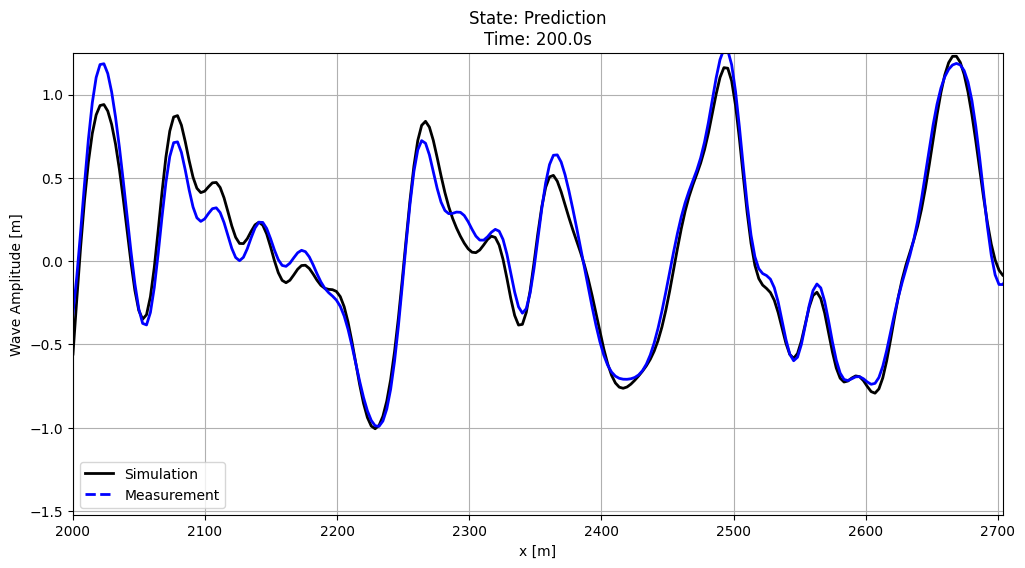

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np 

fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot([], [], lw=2, color="k")
line_pred, = ax.plot([], [], lw=2, color="y", label="Ground Truth")

ax.set_xlim(x[0], x[-1])
ax.set_ylim(np.min(saved_data), np.max(saved_data))
ax.set_xlabel("x [m]")
ax.set_ylabel("Wave Amplitude [m]")
ax.set_title(f"Prediction Time: {0.0:.1f}s")
ax.grid(True)

line_, = ax.plot([], [], lw=2, color="k", label="Simulation")
line__, = ax.plot([], [], lw=2, color="b", linestyle="--", label="Measurement")
ax.legend(loc=3)

def update(frame):
    if frame < saved_data.shape[0]:
        if frame % 20 == 0 or frame % 20 == 19:
            line.set_color("b")
            line.set_linestyle("--")
        else:
            line.set_color("k")
            line.set_linestyle("-")

        ax.set_title("State: Bouncing\n" + f"Time: {saved_time[frame]:.1f}s")
        y = saved_data[frame, :]
        line.set_data(x, y)
        return line,
    elif frame < saved_data.shape[0] + saved_data_2.shape[0] - 1:
        line.set_color("k")
        line.set_linestyle("-")
        f = frame - saved_data.shape[0]
        ax.set_title("State: Prediction\n" + f"Time: {saved_time_2[f]:.1f}s")
        y = saved_data_2[f, :]
        line.set_data(x, y)
        return line,
    else:
        ax.set_title("State: Prediction\n" + f"Time: {200.0:.1f}s")
        y = saved_data_2[-1, :]
        line.set_data(x, y)
        ax.set_xlim(x[cut_index], x[cut_index_2])
        line_pred.set_data(x, y_train[index, :])
        return line,line_pred

ani = animation.FuncAnimation(fig, update, frames=saved_data.shape[0]+saved_data_2.shape[0]+40, blit=True)
ani.save("wave_animation.gif", writer='pillow', fps=15)

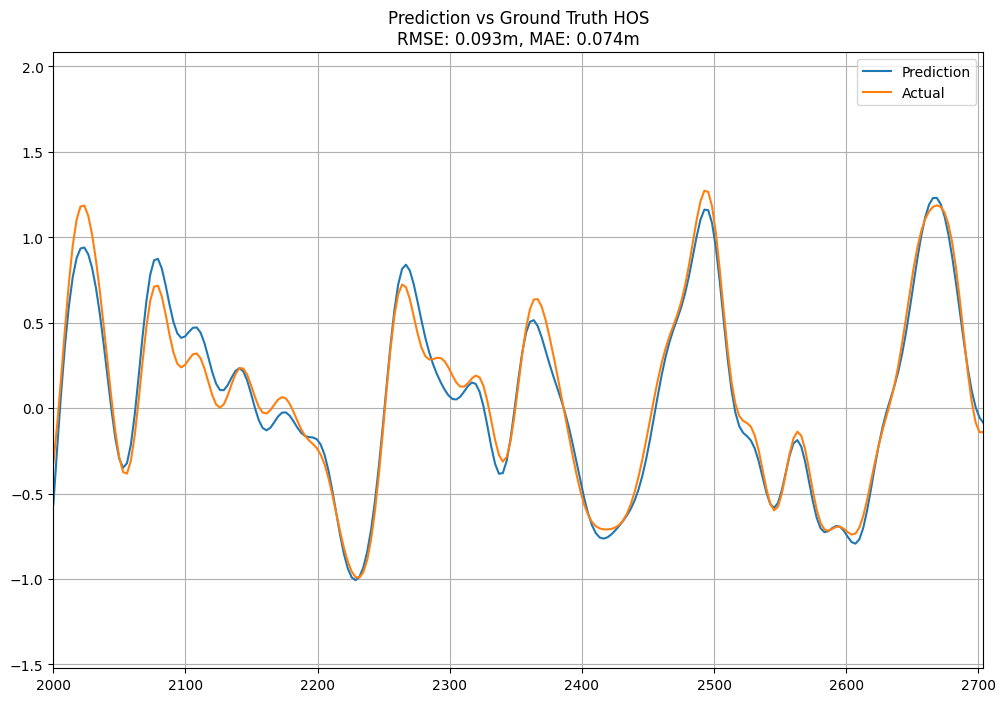

MAE: 7.44813e-02
RMSE: 9.28692e-02


In [ ]:
eta_pred = irfft(y_hat[:y_hat.shape[0]//2])
error = eta_pred[cut_index:cut_index_2] - y_train[index, cut_index:cut_index_2]

plt.figure(figsize=(12, 8))
plt.plot(x, eta_pred, label="Prediction")
plt.plot(x, y_train[index, :], label="Actual")
plt.xlim(x[cut_index], x[cut_index_2])
plt.title("Prediction vs Ground Truth HOS\n" + f"RMSE: {np.sqrt(np.mean(error**2)):.3f}m, MAE: {np.mean(np.abs(error)):.3f}m")
plt.legend()
plt.grid()
plt.show()

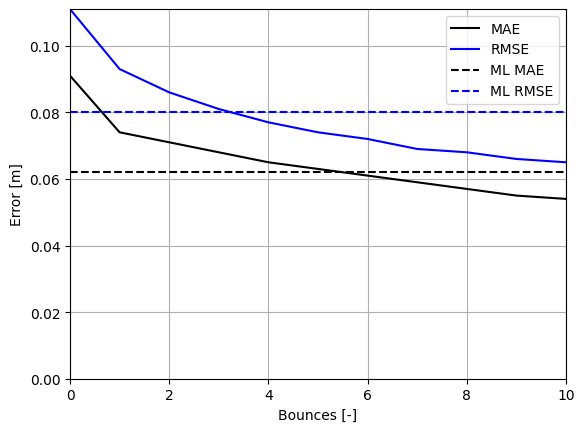

In [ ]:
mae = [0.091, 0.074, 0.071, 0.068, 0.065, 0.063, 0.061, 0.059, 0.057, 0.055, 0.054]
rmse = [0.111, 0.093, 0.086, 0.081, 0.077, 0.074, 0.072, 0.069, 0.068, 0.066, 0.065]

plt.plot(mae, label="MAE", color="k")
plt.plot(rmse, label="RMSE", color="b")
plt.ylim(0, rmse[0])
plt.xlim(0, len(mae)-1)
plt.grid()
plt.xlabel("Bounces [-]")
plt.ylabel("Error [m]")
plt.axhline(y=0.062, label="ML MAE", color="k", linestyle="--")
plt.axhline(y=0.080, label="ML RMSE", color="b", linestyle="--")
plt.legend()
plt.show()

jupyter nbconvert ML_update.ipynb --to pdf --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags="['hide_input']" --TagRemovePreprocessor.remove_all_outputs_tags="['hide_output']" --PDFExporter.preprocessors="['nbconvert.preprocessors.TagRemovePreprocessor']"
